In [15]:
#using Pkg; Pkg.rm("FastJet"); Pkg.add("FastJet")
using LaTeXStrings
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using StatsPlots
using LinearAlgebra
using Corpuscles
#gr()
#theme(:gruvbox_dark)

In [16]:
#using Pkg; Pkg.build("FastJet")
#using Pkg; Pkg.build("LCIO")

Set A: 
Processes: Pmumuh2bb, Pmumuh2cc, Pmumuh2gg
"0_DST" > ".*_DST"

In [4]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

#can use a sort function where the key to sort on is dot(p, p)

leadingParticleIndex (generic function with 1 method)

In [37]:
#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

Strange Events

In [32]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\.0_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_ss[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [57]:
ss_MCleadPDG = []
ss_MCleadingParticlePList = []
ss_PFOleadPDG = []
ss_PFOleadingParticlePList = []
ss_kShortInPiPiEventList_MC = []
ss_kShortInPiPiEventList_PFO = []
ss_lambdaInProtonEventList_MC = []
ss_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_ss
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(ss_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(ss_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(ss_MCleadPDG, pdg)
                    end
                end
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            #大家好，如果你会读懂，我想告诉你很重要的事：加油！
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(ss_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(ss_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(ss_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            
        end
    end
end

UndefVarError: UndefVarError: total_ss_events not defined

Produce figure with MC Particle and Pandora PFO breakdown for all 4 event types\
-Remove muon from everything\
-2 jets\
-Check if theres a K short in the pi pi highest particle events\
-If proton, check if lambda 0\
-just make a dictionary where name maps to value\
Run Z reco over MCParticle & PandoraPFO, compare

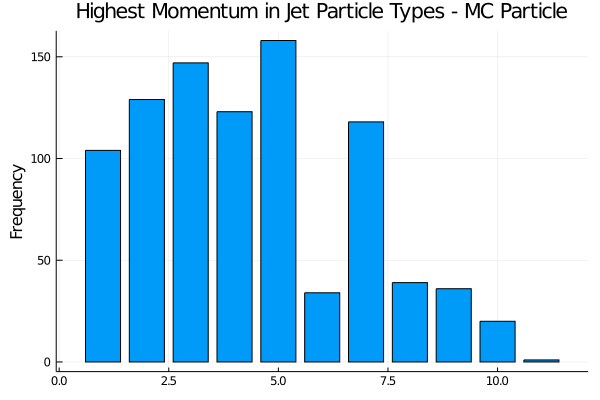

In [34]:
#thisIsntWorkingSoItsInTimeout = [L"\mu^{-}", L"K^{-}", L"\mu^{+}", L"\gamma", L"K^{+}", L"p", L"\pi^{+}", L"\pi^{-}", L"K_{L}^{0}", L"\bar{p}", L"\bar{n}", L"n", L"\bar{\nu}_{\mu}", L"e^{-}", L"e^{+}"]
#Names = ["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "K_L⁰", "p̅", "n̅", "n", "ν̅_μ", "e⁻", "e⁺"]?

ss_MC_y=ss_MCleadPDG
ss_MC_u=unique(ss_MC_y)
ss_MC_d=Dict([(i,count(x->x==i,ss_MC_y)) for i in ss_MC_u])
ss_MC_vals = [ss_MC_d[i] for i in ss_MC_u]
Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in ss_MC_u])
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")
latex = [(Names[convert(Int32, i)]) for i in ss_MC_u]
#xaxis = [L"$(latex(i))" for i in u]
#print(latex)
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", ss_MC_d[i]) for i in u])
#x_axis_names=[L"\gamma", L"K^{+}", L"\pi^{-}", L"K_{l}^{0}", L"\pi^{+}", L"p", L"K^{-}", L"n", L"\bar{p}", L"\bar{n}", L"\bar{v}_{\mu}"]
#dummy=[L"\pi +", L"K +", L"n", L"p", L"\mu -", L"K +", L"K_L {0}", L"\gamma", L"\pi -", L"\mu +", L"p -", L"n -", L"e +", L"e -", L"q"]
bar(ss_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#StatsPlots.savefig("ss_MCleadParticle.pdf")
#print(latex)

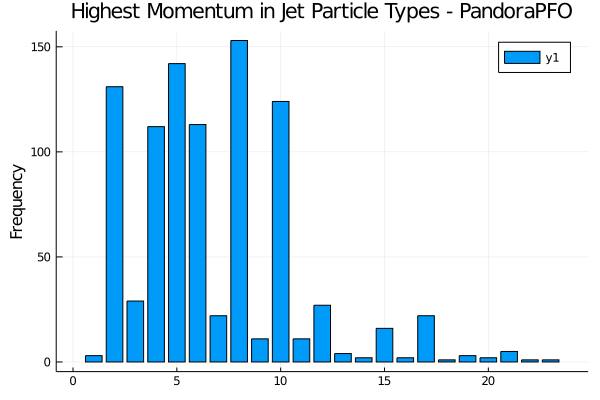

In [35]:
ss_PFO_y=ss_PFOleadPDG
ss_PFO_u=unique(ss_PFO_y)
ss_PFO_d=Dict([(i,count(x->x==i,ss_PFO_y)) for i in ss_PFO_u])
ss_PFO_vals = [ss_PFO_d[i] for i in ss_PFO_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#editNames = Dict([(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\bar n",-13 => "\\mu^{+}",13 => "\\mu^{-}",-14 => "\\overbarv_{u}")])
#latex = ["to_latex(editNames[$(i)]))" for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", d[i]) for i in u])
#x_axis_names=["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "Kₗ⁰", "p", "̄ n", "n", "̅vᵤ", "e⁻", "e⁺"]
StatsPlots.bar(ss_PFO_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - PandoraPFO")
#StatsPlots.savefig("ss_MCleadParticle.pdf")

Same code, botton events

In [20]:
fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_bb[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [45]:
bb_MCleadPDG = []
bb_MCleadingParticlePList = []
bb_PFOleadPDG = []
bb_PFOleadingParticlePList = []
bb_kShortInPiPiEventList_MC = []
bb_kShortInPiPiEventList_PFO = []
bb_lambdaInProtonEventList_MC = []
bb_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_bb
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            if iEvent>100
                break
            end
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(bb_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(bb_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(bb_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(bb_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(bb_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(bb_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

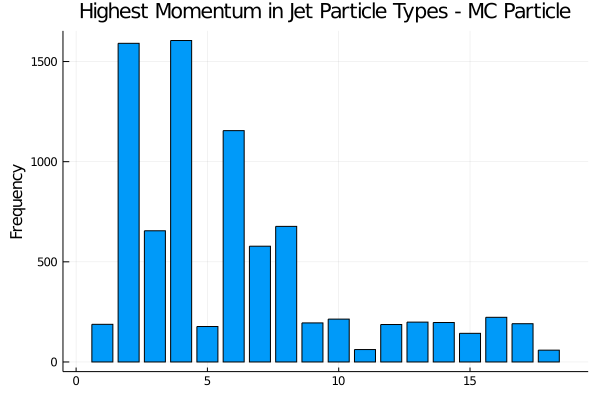

In [46]:
#thisIsntWorkingSoItsInTimeout = [L"\mu^{-}", L"K^{-}", L"\mu^{+}", L"\gamma", L"K^{+}", L"p", L"\pi^{+}", L"\pi^{-}", L"K_{L}^{0}", L"\bar{p}", L"\bar{n}", L"n", L"\bar{\nu}_{\mu}", L"e^{-}", L"e^{+}"]
#Names = ["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "K_L⁰", "p̅", "n̅", "n", "ν̅_μ", "e⁻", "e⁺"]?

bb_MC_y=bb_MCleadPDG
bb_MC_u=unique(bb_MC_y)
bb_MC_d=Dict([(i,count(x->x==i,bb_MC_y)) for i in bb_MC_u])
bb_MC_vals = [bb_MC_d[i] for i in bb_MC_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")
#latex = [latexstring(editNames[convert(Int32, i)]) for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#print(latex)
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", bb_MC_d[i]) for i in u])
x_axis_names=[L"μ⁻", L"K⁻", L"μ⁺", L"γ", L"K⁺", L"p", L"π⁺", L"π⁻", L"Kₗ⁰", L"p", L"̄ n", L"n", L"̅vᵤ", L"e⁻", L"e⁺"]
#dummy=[L"\pi +", L"K +", L"n", L"p", L"\mu -", L"K +", L"K_L {0}", L"\gamma", L"\pi -", L"\mu +", L"p -", L"n -", L"e +", L"e -", L"q"]
bar(bb_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#StatsPlots.savefig("bb_MCleadParticle.pdf")
#editNames[13]

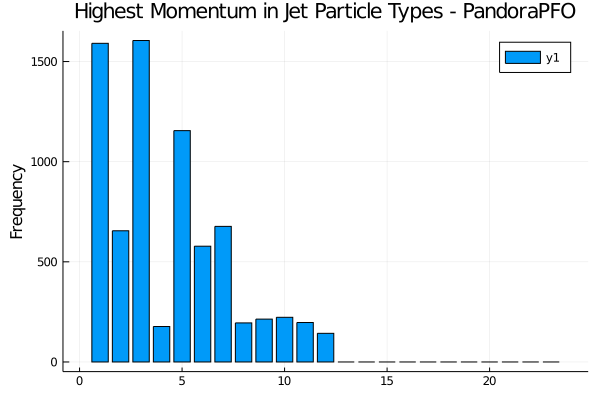

In [47]:
bb_PFO_y=bb_PFOleadPDG
bb_PFO_u=unique(bb_PFO_y)
bb_PFO_d=Dict([(i,count(x->x==i,bb_MC_y)) for i in bb_PFO_u])
bb_PFO_vals = [bb_PFO_d[i] for i in bb_PFO_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#editNames = Dict([(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\bar n",-13 => "\\mu^{+}",13 => "\\mu^{-}",-14 => "\\overbarv_{u}")])
#latex = ["to_latex(editNames[$(i)]))" for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", d[i]) for i in u])
#x_axis_names=["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "Kₗ⁰", "p", "̄ n", "n", "̅vᵤ", "e⁻", "e⁺"]
StatsPlots.bar(bb_PFO_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - PandoraPFO")
#StatsPlots.savefig("bb_MCleadParticle.pdf")

Same code, charm events

In [48]:
fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_cc[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [49]:
cc_MCleadPDG = []
cc_MCleadingParticlePList = []
cc_PFOleadPDG = []
cc_PFOleadingParticlePList = []
cc_kShortInPiPiEventList_MC = []
cc_kShortInPiPiEventList_PFO = []
cc_lambdaInProtonEventList_MC = []
cc_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_cc
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(cc_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(cc_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(cc_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(cc_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(cc_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(cc_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

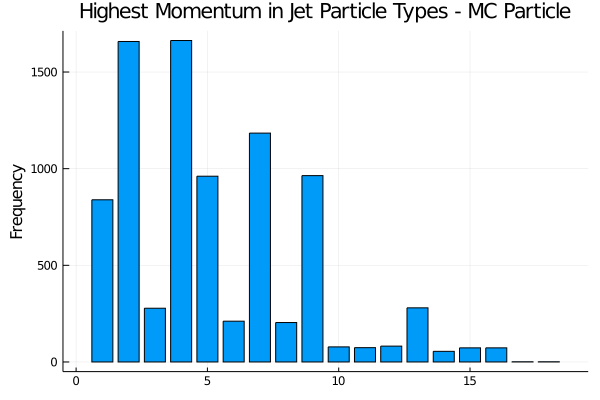

In [50]:
#thisIsntWorkingSoItsInTimeout = [L"\mu^{-}", L"K^{-}", L"\mu^{+}", L"\gamma", L"K^{+}", L"p", L"\pi^{+}", L"\pi^{-}", L"K_{L}^{0}", L"\bar{p}", L"\bar{n}", L"n", L"\bar{\nu}_{\mu}", L"e^{-}", L"e^{+}"]
#Names = ["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "K_L⁰", "p̅", "n̅", "n", "ν̅_μ", "e⁻", "e⁺"]?

cc_MC_y=cc_MCleadPDG
cc_MC_u=unique(cc_MC_y)
cc_MC_d=Dict([(i,count(x->x==i,cc_MC_y)) for i in cc_MC_u])
cc_MC_vals = [cc_MC_d[i] for i in cc_MC_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")
#latex = [latexstring(editNames[convert(Int32, i)]) for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#print(latex)
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", cc_MC_d[i]) for i in u])
x_axis_names=[L"μ⁻", L"K⁻", L"μ⁺", L"γ", L"K⁺", L"p", L"π⁺", L"π⁻", L"Kₗ⁰", L"p", L"̄ n", L"n", L"̅vᵤ", L"e⁻", L"e⁺"]
#dummy=[L"\pi +", L"K +", L"n", L"p", L"\mu -", L"K +", L"K_L {0}", L"\gamma", L"\pi -", L"\mu +", L"p -", L"n -", L"e +", L"e -", L"q"]
StatsPlots.bar(cc_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#StatsPlots.savefig("cc_MCleadParticle.pdf")
#editNames[13]

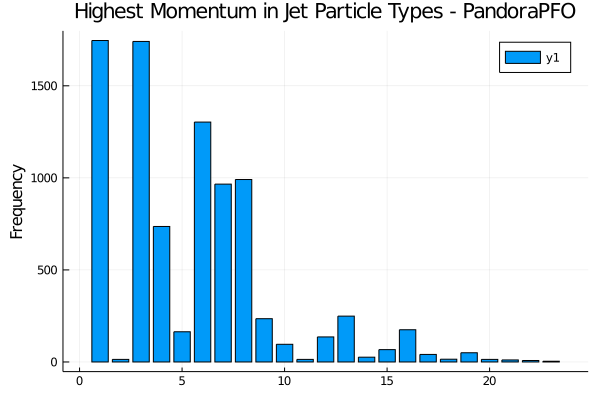

In [51]:
cc_PFO_y=cc_PFOleadPDG
cc_PFO_u=unique(cc_PFO_y)
cc_PFO_d=Dict([(i,count(x->x==i,cc_PFO_y)) for i in cc_PFO_u])
cc_PFO_vals = [cc_PFO_d[i] for i in cc_PFO_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#editNames = Dict([(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\bar n",-13 => "\\mu^{+}",13 => "\\mu^{-}",-14 => "\\overbarv_{u}")])
#latex = ["to_latex(editNames[$(i)]))" for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", d[i]) for i in u])
#x_axis_names=["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "Kₗ⁰", "p", "̄ n", "n", "̅vᵤ", "e⁻", "e⁺"]
StatsPlots.bar(cc_PFO_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - PandoraPFO")
#StatsPlots.savefig("cc_MCleadParticle.pdf")

Same code, gluon events

In [52]:
fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

#fileList = filter(s->occursin(r"dump.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data", join=true))

LCIO.open(fileList_gg[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [53]:
gg_MCleadPDG = []
gg_MCleadingParticlePList = []
gg_PFOleadPDG = []
gg_PFOleadingParticlePList = []
gg_kShortInPiPiEventList_MC = []
gg_kShortInPiPiEventList_PFO = []
gg_lambdaInProtonEventList_MC = []
gg_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_gg
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(gg_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(gg_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(gg_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(gg_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(gg_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(gg_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

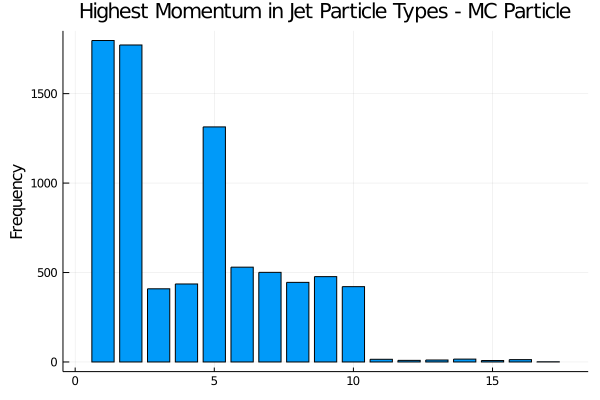

In [54]:
#thisIsntWorkingSoItsInTimeout = [L"\mu^{-}", L"K^{-}", L"\mu^{+}", L"\gamma", L"K^{+}", L"p", L"\pi^{+}", L"\pi^{-}", L"K_{L}^{0}", L"\bar{p}", L"\bar{n}", L"n", L"\bar{\nu}_{\mu}", L"e^{-}", L"e^{+}"]
#Names = ["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "K_L⁰", "p̅", "n̅", "n", "ν̅_μ", "e⁻", "e⁺"]?

gg_MC_y=gg_MCleadPDG
gg_MC_u=unique(gg_MC_y)
gg_MC_d=Dict([(i,count(x->x==i,gg_MC_y)) for i in gg_MC_u])
gg_MC_vals = [gg_MC_d[i] for i in gg_MC_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")
#latex = [latexstring(editNames[convert(Int32, i)]) for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#print(latex)
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", gg_MC_d[i]) for i in u])
x_axis_names=[L"μ⁻", L"K⁻", L"μ⁺", L"γ", L"K⁺", L"p", L"π⁺", L"π⁻", L"Kₗ⁰", L"p", L"̄ n", L"n", L"̅vᵤ", L"e⁻", L"e⁺"]
#dummy=[L"\pi +", L"K +", L"n", L"p", L"\mu -", L"K +", L"K_L {0}", L"\gamma", L"\pi -", L"\mu +", L"p -", L"n -", L"e +", L"e -", L"q"]
bar(gg_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#StatsPlots.savefig("gg_MCleadParticle.pdf")
#editNames[13]

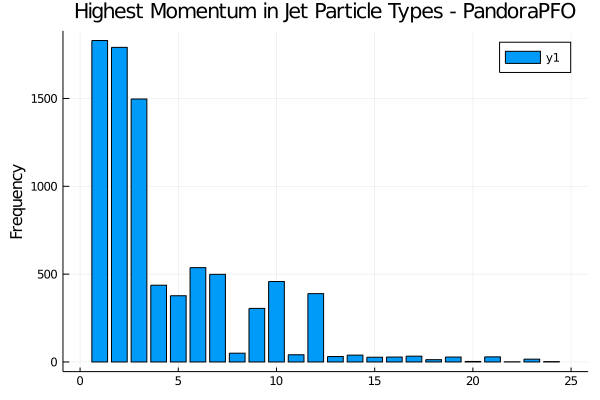

In [55]:
gg_PFO_y=gg_PFOleadPDG
gg_PFO_u=unique(gg_PFO_y)
gg_PFO_d=Dict([(i,count(x->x==i,gg_PFO_y)) for i in gg_PFO_u])
gg_PFO_vals = [gg_PFO_d[i] for i in gg_PFO_u]
#Names = Dict([(i, (Particle(convert(Int64, i)).latex)) for i in u])
#editNames = Dict([(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\bar n",-13 => "\\mu^{+}",13 => "\\mu^{-}",-14 => "\\overbarv_{u}")])
#latex = ["to_latex(editNames[$(i)]))" for i in u]
#xaxis = [L"$(latex(i))" for i in u]
#pdg_names=["$(i)" for i in u]
#data = Dict([("$(i)", d[i]) for i in u])
#x_axis_names=["μ⁻", "K⁻", "μ⁺", "γ", "K⁺", "p", "π⁺", "π⁻", "Kₗ⁰", "p", "̄ n", "n", "̅vᵤ", "e⁻", "e⁺"]
StatsPlots.bar(gg_PFO_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - PandoraPFO")
#StatsPlots.savefig("gg_MCleadParticle.pdf")

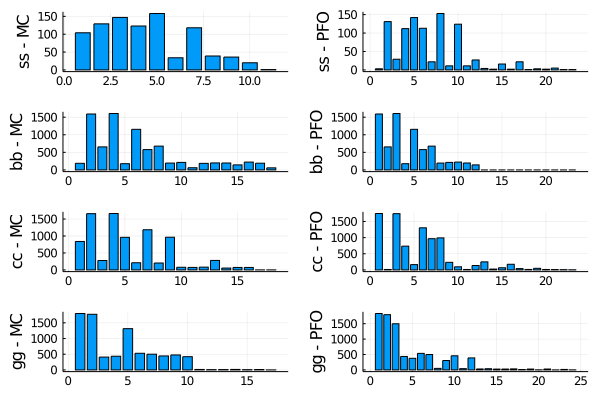

In [71]:
#plot(title="Lead Momentum Particle per Jet - MC Truth and Pandora PFO")
plot(
    StatsPlots.bar(ss_MC_vals, ylabel="ss - MC"),
    StatsPlots.bar(ss_PFO_vals, ylabel="ss - PFO"),
    StatsPlots.bar(bb_MC_vals, ylabel="bb - MC"),
    StatsPlots.bar(bb_PFO_vals, ylabel="bb - PFO"),
    StatsPlots.bar(cc_MC_vals, ylabel="cc - MC"),
    StatsPlots.bar(cc_PFO_vals, ylabel="cc - PFO"),
    StatsPlots.bar(gg_MC_vals, ylabel="gg - MC"),
    StatsPlots.bar(gg_PFO_vals, ylabel="gg - PFO"),
    layout=(4,2),
    legend=false,
    )